In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from src.dt_helpers.lif_dynamics import run_LIF_network
from src.dt_helpers.plotters import visualize_network_activity, visualize_spikes

In [5]:
weights_minicircuit = np.load("../../data/MANC weights/20241118_T1Lminicircuit/W_20241118_T1Lminicircuit.npy")
table_minicircuit= pd.read_csv("../../data/MANC weights/20241118_T1Lminicircuit/wTable_20241118_T1Lminicircuit.csv")
minicircuit_size = (table_minicircuit["class"] != "motor neuron").sum()
send_connections = (weights_minicircuit[np.arange(4)] != 0).any(0)
receive_connections = (weights_minicircuit[:, np.arange(4)] != 0).any(1)
keep = send_connections | receive_connections
weights_minicircuit = weights_minicircuit[keep][:, keep]
table_minicircuit = table_minicircuit[keep]
weights_minicircuit[table_minicircuit["class"] == "motor neuron"] = 0

network_size = minicircuit_size
network_input = np.zeros(keep.sum())
network_input[table_minicircuit["class"] == "descending neuron"] = 1
network_input = network_input[table_minicircuit["class"] != "motor neuron"]

network_weights = weights_minicircuit[:network_size, :network_size].T

In [ ]:
def default_params() -> dict:
    params = {}

    params["V_rest"] = -52e-3  # [V]
    params["V_reset"] = -52e-3  # [V]
    params["V_thresh"] = -45e-3  # [V]
    params["t_refractory"] = 2.2e-3  # [s]
    params["tau_membrane"] = 20e-3  # [s]
    params["tau_synaptic"] = 5e-3  # [s]
    params["w_synaptic"] = 0.275e-3  # [V]
    params["t_delay"] = 1.8e-3  # [s]
    params["membrane_conductance"] = 10e-9  # [S]
    params["V_init"] = -52e-3  # [V]
    params["dt"] = 1e-5  # [s]
    params["simulation_time"] = 2  # [s]
    params["network_input"] = 0.17e-9  # [A]
    params["network_size"] = network_size
    params["network_weights"] = network_weights
    return params


params = default_params()

In [8]:
history_V, history_spikes = run_LIF_network(params, network_input)

(<Figure size 2000x1000 with 5 Axes>,
 array([<Axes: ylabel='Spikes'>, <Axes: ylabel='BDN2\n$V_m$ [mV]'>,
        <Axes: ylabel='17A (E)\n$V_m$ [mV]'>,
        <Axes: ylabel='15A (E)\n$V_m$ [mV]'>,
        <Axes: xlabel='Time (s)', ylabel='16B (I)\n$V_m$ [mV]'>],
       dtype=object))

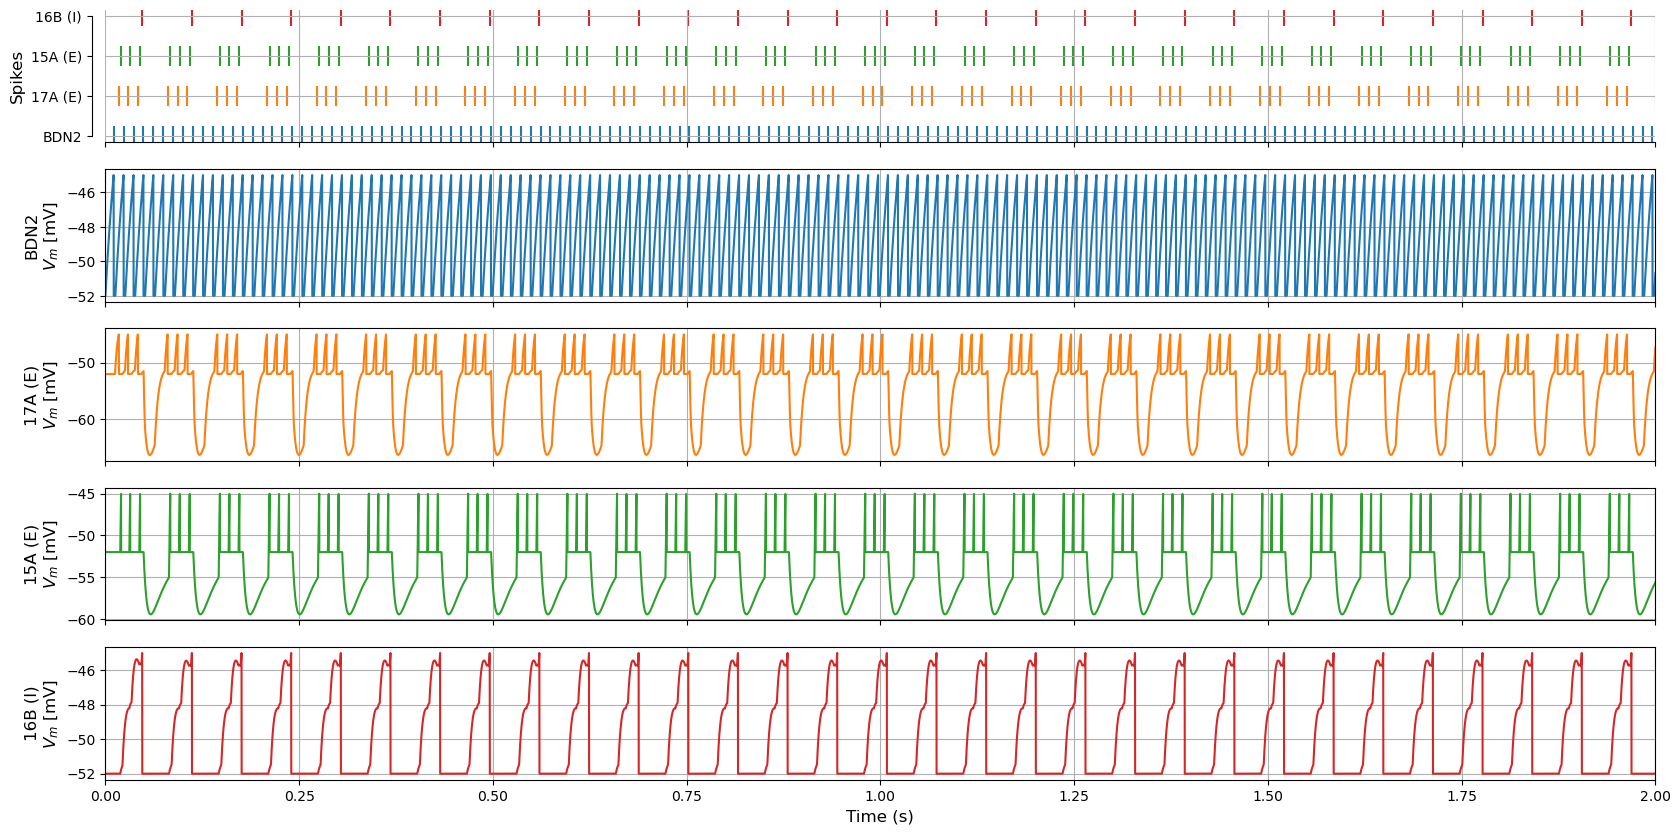

In [9]:
visualize_spikes(
    spike_activity=history_spikes,
    membrane_potential=history_V,
    duration=params["simulation_time"],
    dt=params["dt"],
    neuron_labels=["BDN2", "17A (E)", "15A (E)", "16B (I)"],
    show_plot=False,
)

In [13]:
params["simulation_time"] = 5
network_inputs = np.arange(0.07, 0.4, 0.005) * 1e-9
frequencies_mean = {}
frequencies_std = {}
for net_in in network_inputs:
    frequencies_mean[net_in] = []
    frequencies_std[net_in] = []
    params["network_input"] = net_in
    print(f"Running simulation with network input: {net_in:.2e}")
    history_V, history_spikes = run_LIF_network(params, network_input)
    for i in range(params["network_size"]):
        spike_time_ids = np.where(history_spikes[:, i])[0]
        spike_intervals = np.diff(spike_time_ids)
        if len(spike_intervals) == 0:
            frequencies_mean[net_in].append(0)
            frequencies_std[net_in].append(0)
            continue
        middle_interval = (spike_intervals.max() + spike_intervals.min() / 2) / 2
        burst_start_ids = np.hstack(
            [[spike_time_ids[0]], spike_time_ids[np.where(spike_intervals >= middle_interval)[0] + 1]]
        )
        oscillation_frequency = 1 / (np.diff(burst_start_ids) * params["dt"])
        frequencies_mean[net_in].append(oscillation_frequency.mean())
        frequencies_std[net_in].append(oscillation_frequency.std())

Running simulation with network input: 7.00e-11
Running simulation with network input: 7.50e-11
Running simulation with network input: 8.00e-11
Running simulation with network input: 8.50e-11
Running simulation with network input: 9.00e-11
Running simulation with network input: 9.50e-11
Running simulation with network input: 1.00e-10
Running simulation with network input: 1.05e-10
Running simulation with network input: 1.10e-10
Running simulation with network input: 1.15e-10
Running simulation with network input: 1.20e-10
Running simulation with network input: 1.25e-10
Running simulation with network input: 1.30e-10
Running simulation with network input: 1.35e-10
Running simulation with network input: 1.40e-10
Running simulation with network input: 1.45e-10
Running simulation with network input: 1.50e-10
Running simulation with network input: 1.55e-10
Running simulation with network input: 1.60e-10
Running simulation with network input: 1.65e-10
Running simulation with network input: 1

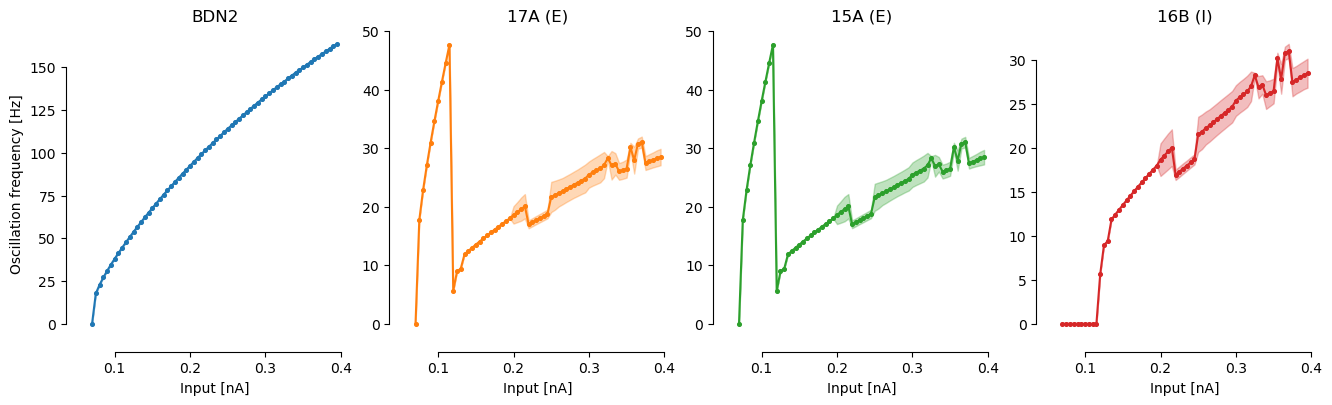

In [14]:
means = np.array([v for v in frequencies_mean.values()])
stds = np.array([v for v in frequencies_std.values()])
net_ins = np.array(list(frequencies_mean.keys())) * 1e9
neuron_labels = ["BDN2", "17A (E)", "15A (E)", "16B (I)"]
fig, axes = plt.subplots(1, params["network_size"], figsize=(4 * params["network_size"], 4), sharex=True)
for i in range(params["network_size"]):
    axes[i].plot(net_ins, means[:, i], c=f"C{i}")
    axes[i].scatter(net_ins, means[:, i], color=f"C{i}", s=7)
    axes[i].fill_between(net_ins, means[:, i] - stds[:, i], means[:, i] + stds[:, i], alpha=0.3, color=f"C{i}")
    axes[i].set_xlabel("Input [nA]")
    axes[i].set_title(neuron_labels[i])
    sns.despine(offset=10, trim=True, ax=axes[i])
axes[0].set_ylabel("Oscillation frequency [Hz]")
plt.show()